<a href="https://colab.research.google.com/github/JenFaith/DS-Unit-2-Linear-Models/blob/master/Faith___DS_Sprint_Challenge_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1*

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [286]:
%%capture
# If you're in Colab...
import sys
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*

 
# Sprint Challenge: Predicting Home Prices in Iowa 🏠

The goal of this assignment is to build a regression model that can predict the sale price of a house in Aimes, Iowa.

# Directions 

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Import training data.
- **Task 2 (`stretch goal`):** Create scatter plot.
- **Task 3:** Split data into feature matrix and target vector.
- **Task 4:** Split data into training and validation sets.
- **Task 5:** Establish baseline mean absolute error.
- **Task 6:** Build and train linear regression model.
- **Task 7:** Build and train ridge regression model.
- **Task 8:** Calculate mean absolute error for training and validation sets.
- **Task 9:** Calculate $R^2$ for validation set.
- **Task 10:** Make predictions based on test set.
- **Task 11 (`stretch goal`):** Get below 18,000 for test set MAE. 
- **Task 12 (`stretch goal`):** Plot model coefficients.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn` 

# Tasks

## I. Wrangle Data

**Task 1:** Since real estate prices fluctuate over time, it's important to index the houses in this dataset using the year in which they were sold. First, load the dataset into a DataFrame named `df` and find the column that states the year sold. Next, modify the code below so that `Yr_Sold` column is parsed as a datetime object and set as the index.

In [287]:
'''T1: Import data into DataFrame `df`.'''
import pandas as pd

url_train = 'https://drive.google.com/uc?export=download&id=1tmYLQ1RwIgjI_d66PWnlXU-5D_VxtiQc'
df = pd.read_csv(url_train,
                 parse_dates = ['Yr_Sold'],
                 index_col = 'Yr_Sold')

#df = df.drop(columns = ['Exterior_1st', 'Condition_1', 'Condition_2', 'Exter_Qual', 'Paved_Drive'])

#Testing Dropping the Outlier Prices
# df = df[(df['SalePrice'] >= np.percentile(df['SalePrice'], 0.5)) & 
#        (df['SalePrice'] <= np.percentile(df['SalePrice'], 99.5))]

In [288]:
df['SalePrice'].describe()

count      2564.000000
mean     181433.289392
std       80410.055316
min       13100.000000
25%      129887.500000
50%      160350.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [262]:
df.shape

(2564, 41)

In [ ]:
# There are no null values
df.isnull().sum()

#Checking all categories are in expected format 
#(i.e. checking numerical values are int and floats)
#all appear to be as expected so I didn't make changes
df.info()

#Checking for number of categories
#As expected so I did not delete out any columns yet
#Some of the values like neighborhood had high cardinality (k = 28),
#However, my first instinct is that neighborhoods will be an important predictor of price
df.nunique()

**Task 1 Testing**

In [291]:
'''T1 Testing.'''
assert isinstance(df, pd.DataFrame), '`df` is not a DataFrame. Did you import the data?'
assert len(df) == 2564, 'DataFrame `df` has the wrong number of rows.'
assert isinstance(df.index, pd.DatetimeIndex), '`df` does not have a datetime index.'

**Task 2 (`stretch goal`):** Create a scatter plot that shows `'SalePrice'` as a function of `'Gr_Liv_Area'`. Be sure to label the axes of your plot.

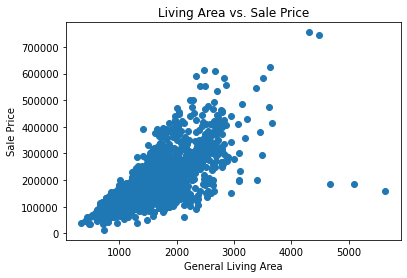

In [292]:
import matplotlib.pyplot as plt

# YOUR CODE HERE

plt.scatter(df['Gr_Liv_Area'], df['SalePrice'])
plt.title('Living Area vs. Sale Price')
plt.xlabel('General Living Area')
plt.ylabel('Sale Price');

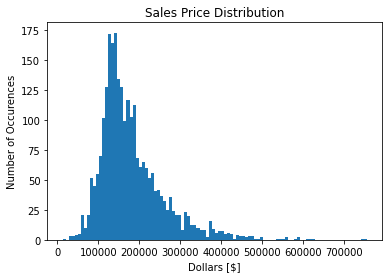

In [319]:
#A visual look at Sales Price Distribution

plt.hist(df['SalePrice'], bins=100)
plt.title('Sales Price Distribution')
plt.ylabel('Number of Occurences')
plt.xlabel('Dollars [$]');

## II. Split Data

**Task 3:** Since you're building a model to predict the price at which a house will be sold, your target is the `'SalePrice'` column. Split the DataFrame `df` into the target vector `y` and the feature matrix `X`. 

In [293]:
'''T3: Split `df` into `X` and `y`.'''

target = 'SalePrice'
y = df[target]
X = df.drop(columns=target)

**Task 3 Testing**

In [294]:
'''T3 Tests'''
assert y.shape == (2564,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert X.shape == (2564, 45), '`X` has the wrong number of columns or rows.'
assert 'SalePrice' not in X.columns, 'Target is still part of feature matrix.' 

**Task 4:** Split `X` and `y` into training, validation, and test sets. Since housing prices fluctuate over time, you should use the time-based cutoff method. 

- Training: Homes sold before 2009
- Validation: Homes sold during 2009

In [295]:
'''T4: Split `X` and `y` into training, validation, and testing sets.'''

# YOUR CODE HERE
#Training, validating, and testing masks
mask_train = df.index < '2009-01-01'
mask_val = (df.index > '2008-12-31') & (df.index < '2010-01-01')

X_train = X[mask_train]
y_train = y[mask_train]

X_test = X[~mask_train]
y_test = y[~mask_train]

X_val = X[mask_val]
y_val = y[mask_val]

In [296]:
#Double checking a few of the new sets
y_val.head()

Yr_Sold
2009-01-01    124500
2009-01-01    157000
2009-01-01    345000
2009-01-01    189500
2009-01-01    270000
Name: SalePrice, dtype: int64

**Task 4 Testing**

In [297]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 1920, 'Your training set has the wrong number of rows.'
assert len(X_val) == len(y_val) == 644, 'Your validation set has the wrong number of rows.'

## III. Set Baseline

**Task 5:** Before you can create a model to predict sale price, you need to establish a baseline. First, calculate the mean housing price for your training set. Next, calculate the *mean absolute error* for a model that always predicts that mean. Be sure to assign the mean absolute error to a variable named `baseline_mae`.

In [298]:
'''T5: Calculate baseline mean absolute error.'''
from sklearn.metrics import mean_absolute_error

# YOUR CODE HERE
y_mean = [y_train.mean()] * len(y_train)

baseline_mae = mean_absolute_error(y_train, y_mean)

print('Baseline MAE:', baseline_mae)

Baseline MAE: 58502.9394639757


**Task 5 Testing**

In [299]:
'''T5 Tests'''
assert isinstance(baseline_mae, float), '`baseline_mae` is not a `float`. Have you assigned a value to this variable name?'

## IV. Build Models

**Task 6:** Build and train a linear regression model named `model_lr` that predicts home sale price. Your model should have the following components:

- A `OneHotEncoder` for categorical features.
- A `StandardScaler` so that you can compare your model coefficients after training.
- A `pipeline` that combines transformers and predictor.

**Tip:** For your `OneHotEncoder`, `use_cat_names` should be set to `True`.

In [300]:
'''T6: Build and train LinearRegression model.'''
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from category_encoders import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold


#YOUR CODE HERE
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    #VarianceThreshold(threshold=(.8 * (1 - .8))),
    #SelectKBest(k=25),
    #I thought maybe I was overfitting the model but cutting down on features
    #made things 2x as bad
    LinearRegression()
)

model_lr.fit(X_train, y_train);


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


**Task 6 Testing**

In [301]:
'''T6 Tests'''
from sklearn.pipeline import Pipeline
assert isinstance(model_lr, Pipeline), '`model_lr` is not a pipeline.'
assert len(model_lr.named_steps) > 1, 'Your `model_lr` pipeline is missing components.'

**Task 7:** Build and train a ridge regression model named `model_r` that predicts home sales price. Your model should include the following components:

- A `OneHotEncoder` for categorical features.
- A `StandardScaler` so that you can compare your model coefficients after training.
- A `pipeline` that combines transformers and predictor.

**Tip:** If you combine a `StandardScaler` transformer with a `Ridge` predictor, you should set the `normalize` argument for the latter to `False`.

In [302]:
'''T7. Build and train Ridge model.'''
from sklearn.linear_model import Ridge

# YOUR CODE HERE

model_r = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    Ridge(alpha=1.0, normalize=False)
)

model_r.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


**Task 7 Testing**

In [303]:
assert isinstance(model_r, Pipeline), '`model_r` is not a pipeline.'
assert len(model_r.named_steps) > 1, 'Your `model_r` pipeline is missing components.'

## V. Check Metrics

**Task 8:** Compare your models by calculating their mean absolute error for the training and validation sets. You should assign these to the variables `training_mae` and `validation_mae`, respectively. Your `validation_mae` should be lower than your `baseline_mae`.

##**Something has gone wrong with LR Model**
--> Come back to this

I believe this is because of overfitting.

In [304]:
'''T8: Compare model metrics, MAE.'''
# YOUR CODE HERE
#Linear Regression Model
model_lr_training_mae = mean_absolute_error(y_train, model_lr.predict(X_train))
model_lr_validation_mae = mean_absolute_error(y_val, model_lr.predict(X_val))


#Ridge Regression Model
model_r_training_mae = mean_absolute_error(y_train, model_r.predict(X_train))
model_r_validation_mae = mean_absolute_error(y_val, model_r.predict(X_val))


print('Linear Regression Model')
print('Training MAE:', model_lr_training_mae)
print('Validation MAE:', model_lr_validation_mae)
print()
print('Ridge Regression Model')
print('Training MAE:', model_r_training_mae)
print('Validation MAE:', model_r_validation_mae)

Linear Regression Model
Training MAE: 16252.725113683535
Validation MAE: 1.0835239882409024e+16

Ridge Regression Model
Training MAE: 16119.822691743922
Validation MAE: 17986.919803129713


Results when I did remove outliers/drop columns...


Ridge Regression Model

Training MAE: 15231.805395460127

Validation MAE: 17086.42998902252

**Task 8 Testing**

In [305]:
'''T8 Tests'''
assert isinstance(model_lr_training_mae, float), '`model_lr_training_mae` is not a float. Did you assign a value to this variable?'
assert isinstance(model_lr_validation_mae, float), '`model_lr_validation_mae` is not a float. Did you assign a value to this variable?'
assert isinstance(model_r_training_mae, float), '`model_r_training_mae` is not a float. Did you assign a value to this variable?'
assert isinstance(model_r_validation_mae, float), '`model_r_validation_mae` is not a float. Did you assign a value to this variable?'

**Task 9:** Compare your two models by calculating their $R^2$ score for the **validation data**.

In [306]:
'''T9: Compare model metrics, R^2.'''
# YOUR CODE HERE
model_lr_r2_score = model_lr.score(X_val, y_val)
model_r_r2_score = model_r.score(X_val, y_val)

print('Linear Regression R^2:', model_lr_r2_score)
print('Ridge Regression R^2:', model_r_r2_score)

Linear Regression R^2: -7.639381424191251e+24
Ridge Regression R^2: 0.888738016537792


**Task 9 Testing**

In [307]:
'''T9 Tests'''
assert isinstance(model_lr_r2_score, float), '`model_lr_r2_score` is not a float. Did you assign a value to this variable?'
assert isinstance(model_r_r2_score, float), '`model_r_r2_score` is not a float. Did you assign a value to this variable?'
assert model_lr_r2_score <= 1, 'The maximum value for an R^2 score is 1.'
assert model_r_r2_score <= 1, 'The maximum value for an R^2 score is 1.'

**Task 10:** Based on the metrics above, choose the best of your two models and generate an array of predictions `y_pred` using the test set below.

**Note:** Make sure that you import and clean the test set *exactly the same way* you did with the training set at the start of this notebook.

In [308]:
url_test = 'https://drive.google.com/uc?export=download&id=1y9u8cOWprTjruw8E-ct1c7YaEytToqd_'
X_test = pd.read_csv(url_test,
                     parse_dates = ['Yr_Sold'],
                     index_col = 'Yr_Sold')
# YOUR CODE HERE

y_pred = model_r.predict(X_test)
print('My predictions:', y_pred[:3])

My predictions: [219431.82052472 104354.37322437 159396.82083221]


**Task 10 Testing:** There is a hidden test in the cell below. When you submit your notebook to Canvas, your test MAE will be calculated. In order to get the point for this task, your test MAE must be below 58,000.

**Tip:** Use your validation MAE to estimate what your test MAE will be.

In [309]:
import numpy as np
assert isinstance(y_pred, np.ndarray), '`y_pred` should be type `ndarray`.'
assert y_pred.shape == (340,), '`y_pred` should be a 1-dimentional array with 340 predictions.'
# Your test MAE will be printed out below when you submit your assignment.

**Task 11 (`stretch goal`):** There's no code to write for this task. Below is another testing cell that will calculate the MAE for your test set. In order to get the point for this task, your test MAE must be below 18,000.

**Tip:** Are there any **hyperparameters** in your model that you could adjust to improve performance? 

In [310]:
assert isinstance(y_pred, np.ndarray), '`y_pred` should be type `ndarray`.'
assert y_pred.shape == (340,), '`y_pred` should be a 1-dimentional array with 340 predictions.'
# Your test MAE will be printed out below when you submit your assignment.

## VI. Explain Model

**Task 12 (`stretch goal`):** Create a horizontal barchart for your best performing model that shows the ten most important features for the model's predictions. Don't forget to label your axes!

In [311]:
# YOUR CODE HERE
coefficients = model_r.named_steps['ridge'].coef_
len(coefficients)

216

In [312]:
feat_names = model_r.named_steps['onehotencoder'].get_feature_names()
len(feat_names)

216

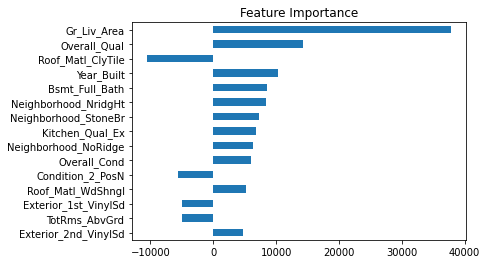

In [200]:
pd.Series(coefficients, index=feat_names).sort_values(key=abs).tail(15).plot(kind='barh')
plt.title('Feature Importance');

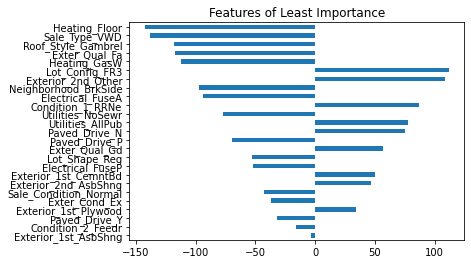

In [258]:
pd.Series(coefficients, index=feat_names).sort_values(key=abs).head(25).plot(kind='barh')
plt.title('Features of Least Importance');

In [ ]:
#cut 'Exterior_1st', 'Condition_1', 'Condition_2', 'Exter_Qual', 'Paved_Drive'

In [253]:
df.columns

Index(['1st_Flr_SF', 'Bedroom_AbvGr', 'Bldg_Type', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Central_Air', 'Condition_1', 'Condition_2',
       'Electrical', 'Exter_Cond', 'Exter_Qual', 'Exterior_1st',
       'Exterior_2nd', 'Foundation', 'Full_Bath', 'Functional', 'Gr_Liv_Area',
       'Half_Bath', 'Heating', 'Heating_QC', 'House_Style', 'Kitchen_AbvGr',
       'Kitchen_Qual', 'Land_Contour', 'Land_Slope', 'Lot_Area', 'Lot_Config',
       'Lot_Shape', 'MS_SubClass', 'MS_Zoning', 'Mas_Vnr_Type', 'Mo_Sold',
       'Neighborhood', 'Overall_Cond', 'Overall_Qual', 'Paved_Drive',
       'Roof_Matl', 'Roof_Style', 'SalePrice', 'Sale_Condition', 'Sale_Type',
       'Street', 'TotRms_AbvGrd', 'Utilities', 'Year_Built', 'Year_Remod/Add'],
      dtype='object')

In [259]:
df['Paved_Drive'].unique()

array(['Y', 'P', 'N'], dtype=object)